# Homework 4: Building and Training Convolutional Networks
When you download the file into your Google Drive, please insert your name and student ID number here by replacing my name in the fields below.

Sai Chandana Vallam Kondu, 023810339



# Convolutional Neural Networks

Welcome to your fourth assignment! You have previously built and trained a deep Fully Connected (FC) Neural Network with L layers using Pytorch. In this  assignment, you will use PyTorch to put together a ConvNet and train it on the CIFAR-10 image data using a softmax backend.

In this notebook, you will implement and train a CNN to learn what is in the ten classes of images. This will enable you to start learning the PyTorch framework for deep learning.

*   Uses the PyTorch dataloader function
*   Use PyTorch *nn* to create an instance of a convolutional network
*   Visualization functions to see what is happening as the network goes deeper.

**After this assignment you will be able to:**
- Alter the structure of a model.
- Explain how a ConvNet works with its successive layers.
- Visualize results from a multiclass classifier using a heatmap and a confusion matrix.

**There code that you need to fill in this assignment**
See sections 3.1, 3.2, and 3.3.

**There are questions that you need to answer in this assignment**
The questions are in section 6!



## 1.0 - Import packages


Now, let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- pytorch
- pytorch nn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(2023)

## 2 - Outline of the Assignment

 Here is an outline of this assignment, you will:

1.  Read in the CIFAR-10 training and testing data
2.  Review how minibatches are implemented in PyTorch.
3.  Create a PyTorch Model of a CNN using the module function in PyTOrch
4.  Choose an optimizer and objective function for the model.
5.  Train the model.
6.  Visual the results at selected layers of the network.



### 2.1 Read in and process the data set
PyTorch provides data loaders for common data sets used in vision applications, such as MNIST, CIFAR-10 and ImageNet through the [*torchvision*](https://pytorch.org/docs/stable/torchvision/index.html) package. The *torchvision* package consists of popular datasets, model architectures, and common image transformations for computer vision. Other handy tools are the *torch.utils.data.DataLoader* that we will use to load the data set for training and testing and the *torchvision.transforms*, which we will use to compose a two-step process to prepare the data for use with the CNN.

First step is to convert Python Image Library (PIL) format
to PyTorch tensors.

Second step is used to normalize the data by specifying a
mean and standard deviation for each of the three channels.
This will convert the data from [0,1] to [-1,1]

Normalization of data should help speed up conversion and
reduce the chance of vanishing gradients with certain
activation functions.

There are 50000 training examples and 10000 testing examples in the CIFAR-10 dataset at https://www.cs.toronto.edu/~kriz/cifar.html. for more details see: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

Code from: [Stefan Fiott](https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/)

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Initialize transform function to convert to PyTorch tensors
# Normalize: standardizes each channel of the input using a mean of 0.5 and a std
# of 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

print(len(trainset), ' training images')
print(trainset.class_to_idx)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Set up a batch data loader for image display
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170498071/170498071 [00:01<00:00, 104734448.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
50000  training images
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Files already downloaded and verified


### 2.2 Display the images

Using the trainloader we will now get a random batch of 4 training images and plot them to see what CIFAR-10 images look like.

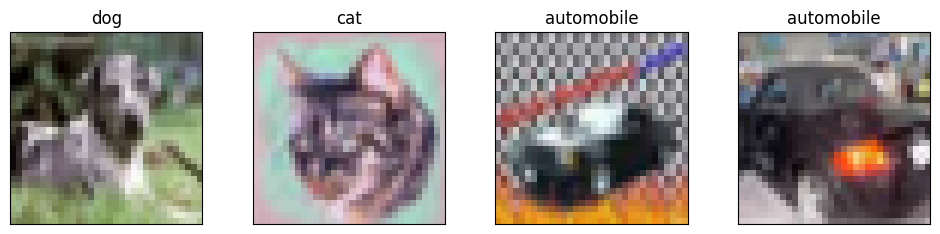

In [ ]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)


# can change to testloader to see four test images
data_iter = iter(trainloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

## 3 - Setting up a Simple Convolutional Network

The network has the following layout,

*Input > Conv (ReLU) > MaxPool > Conv (ReLU) > MaxPool > FC (ReLU) > FC (ReLU) > FC (SoftMax) > 10 outputs*


where:

*Conv* is a convolutional layer, *ReLU* is the activation function, *MaxPool* is a pooling layer, *FC* is a fully connected layer and *SoftMax* is the activation function of the output layer.


## 3.1 Layer dimensions

```
Layer Name    | Layer Size
______________|______________________________________________________
Input         | 32x32x3, i.e., 3 channels each of size 32x32 pixels
Conv Layer 1  | 5x5x3 filters, s=1, p="same", 16 slices
Max Pool 1    | 2x2 with stride = 2
Conv Layer 2  | 3x3x16 filters, s=1, p="valid", 32 slices
Max Pool 2    | 2x2 with stride = 2
FC 1          |  (1568) x 200 Nodes + bias
FC 2          |  200 by 84 Nodes + bias
FC 3          |  84 by 10 Nodes + bias
Output        | 10 Nodes
```



**PyTorch Functions**

*Conv2d(n_input_channels, n_output_channels, f(filter size))*

MaxPool2d(size, stride)

nn.Linear(input_dim, output_dim)*





**Fill in the code defining the model below.**


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HW3Net(nn.Module):
    def __init__(self):
        super(HW3Net, self).__init__()
        # define each layer here
        self.conv1 = nn.Conv2d(3, 16, 5,stride=1,padding="same")
        self.pool =  nn.MaxPool2d(2, 2)
        self.conv2 =  nn.Conv2d(16, 32, 3,stride=1,padding="valid")
        self.fc1 =  nn.Linear(1568, 200)
        self.fc2 =  nn.Linear(200, 84)
        self.fc3 =  nn.Linear(84, 10)

    def forward(self, x):
      # Define the forward Path of the model here
      # Convolution and pooling layers
        # Convolution Layer 1
        x = self.pool(F.relu(self.conv1(x)))
        # Convolution Layer 2
        x = self.pool(F.relu(self.conv2(x)))

        # reshape the output for the FC layers
        # Hint: replace None with the product of the dimensions of the Conv layer 2 after pooling
        x = x.view(-1, 1568)

        # Fully Connected layers
        x = F.relu(self.fc1(x))  #FC Layer 1
        x = F.relu(self.fc2(x))  #FC Layer 2
        x = self.fc3(x)  #FC Layer 3
        return x

# Instantiate your network as net
net = HW3Net()
print(net)

HW3Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=1568, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3.2 - Defining the Loss Function and Optimization

Since we are classifying images into more than two classes we will use cross-entropy as a loss function. To optimize the network we will employ stochastic gradient descent (SGD) with momentum to help get us over local minima and saddle points in the loss function space. Use a learning rate of 0.001 and a momentum value of 0.9.

Look at the documentation in torch.nn for the loss function(https://pytorch.org/docs/stable/nn.html#loss-functions) and torch.optim to find the proper optimization function (https://pytorch.org/docs/stable/optim.html).


Fill in the code defining the loss function and optimizer below. Try to use at least one type of regularization.

In [ ]:
import torch.optim as optim

# Select the appropriate criteria from torch.optim package:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epoch = 6 #run for 1 epoch first until you feel good about your model.
batch_size = 16

### 3.3 - Training the Network

We will now set up to train the network using the trainloader data, by going over all the training data in batches of 16 images, and repeating the whole process num_epoch times. Every 1000 batches (16K images), we report on training progress by printing the current epoch and batch number along with the running loss value.

Once training is complete, we will save the model parameters to disk. This will make it possible to load the model parameters from disk the next time we run this notebook and thus not have to train the model again, saving some time. More details on how to save and load model parameters can be found here.



Note: Ignore the warning shown below. It is a known bug in PyTorch that was reported this summer.
*/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)*
.


In [ ]:
import os
pwd = os.getcwd()
modelpath = "cifar-10-cnn-model.pt"
full_modelpath = os.path.join(pwd, modelpath)
print(full_modelpath)

/content/cifar-10-cnn-model.pt


In [ ]:
#Set flags for saving and loading file
load_flag = "FALSE" #if true, a previously saved model will be loaded

In [ ]:


trainloader = torch.utils.data.DataLoader(trainset, batch_size,
                                          shuffle=True, num_workers=2)

# Saving your model is useful if you would like to save your results then go back and train more later.
if (load_flag == "TRUE"):#os.path.isfile(full_modelpath):
    # load trained model parameters from disk
    net.load_state_dict(torch.load(full_modelpath))
    print('Loaded model parameters from disk, so no need to retrain.')
    net.eval()

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0 # compute loss per epoch
    # Loop through iterable containing training data
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # forward pass
        outputs = net(inputs)

        # compute loss
        loss = criterion(outputs,labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Perform backpropagation 2 steps, loss then optimizer
        # Loss computation
        loss = criterion(outputs, labels)
        loss.backward()
        # Optimizer
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    print('Finished Epoch %d',(epoch+1))

# save the trained model to disk
torch.save(net.state_dict(), full_modelpath)
print('Saved model parameters to disk.')

[1,  1000] loss: 2.249
[1,  2000] loss: 1.931
[1,  3000] loss: 1.687
Finished Epoch %d 1
[2,  1000] loss: 1.503
[2,  2000] loss: 1.421
[2,  3000] loss: 1.348
Finished Epoch %d 2
[3,  1000] loss: 1.255
[3,  2000] loss: 1.216
[3,  3000] loss: 1.173
Finished Epoch %d 3
[4,  1000] loss: 1.081
[4,  2000] loss: 1.051
[4,  3000] loss: 1.024
Finished Epoch %d 4
[5,  1000] loss: 0.952
[5,  2000] loss: 0.939
[5,  3000] loss: 0.918
Finished Epoch %d 5
[6,  1000] loss: 0.837
[6,  2000] loss: 0.842
[6,  3000] loss: 0.840
Finished Epoch %d 6
Saved model parameters to disk.


## 4. Testing the Model
Now that the network is trained, we can evaluate how it performs on the testing data set. Start with four random images from the testing data set and their corresponding labels.

**Four Random Images and their class (category) predictions**

First, we input four images to the trained network to get class (label/category) predictions.

The network outputs a 2D tensor (array) of size 4x10, a row for each image and a column for each category. The values are raw outputs from the linear transformation, $z^{[l]} = W^{[l]} a^{[l-1]} + b^{[l]}$

The category predicted for each image (row) is thus the column index containing the maximum value in that row.

In [ ]:
data_iter = iter(testloader)
images, labels = data_iter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

outputs = net(images)
outputs

 **Probability Score and Class Prediction**

 To get a probability score, use the *nn.Softmax* function on the raw output as shown below. The predicted category is the one with the maximum probability score.

In [ ]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print("Probability Score:",sm_outputs)

probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

**Testing Predictions for all Test Images**

We will now loop through all of the test images to see how we did. I got an accuracy of around 65% after 5 epochs, around 70-72% for 10 epochs.

In [ ]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

## 5. Visualizing the Results
Now that the network is trained, we can visualize the results to investigate the conditions where the model works well and when it makes mistakes using some visualization tools from statistical graphics.

**Confusion Matrix Computation**

The model performed much better than random guessing, which would give us an accuracy of 10% since there are ten categories in CIFAR-10. The confusion matrix computes the accuracy of the model per category so we can see if there are particular categories that are being confused with one another. This matrix can be visualized as a heatmap. The squares show the matches between the input images and what the model guessed.

What type of image were deer misclassified as most often?

In [ ]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

**Confusion Matrix**

From the above heatmap visualisation, we can see where the best accuracy was achieved, the darkest shades present on the main diagonal.

To understand precisely which categories were most commonly confused, we can print the percentage and absolute values of the confusion matrix below.

In [ ]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

# 6. Analysis Questions

Your homework score will be based on
1. the coding of the model (20 points) in sections 3.1, 3.2 and 3.3.
2. the answers of the questions below.

## 6.1 Convolution Nets Questions (20 points)
**Question 1**
What categories of images were identified most accurately? Which categories were confused with each other more often? Use your results from Part 5 to inform your answers. Speculate on why some categories of image were more difficult to work with.

**Question 2** Compare your results with those of HW 3 in terms of accuracy across classes, speed of training, and number of parameters.

**Question 3** Describe two methods for data augmentation and how they might improve system performance.

**Extra Credit** (Up to 5 additional points)
If you have time, try to implement increasing the size of the training data set by using the PyTorch data augmentation code See <a href="https://pytorch.org/vision/0.15/transforms.html" target="_blank" rel="noopener">Transforming and Augmenting Images</a>. There are some good tutorials on the PyTorch site for you to review. You must cite any tutorials/examples that you used and clearly state which type of augmentation you tried.

## 6.2 Concept Questions (10 points)
Answer each question and give an explanation for why it is true.

1. Which of the following are true of pooling layers in CNNs?
a. They reduce the size of the input to the next layer.
b. They increase the number of parameters.
c. They reduce the number of connections to the next layer.
d. They reduce the number of parameters

> **Answer:** Both (a) and (c) are True.

2. Which of the following are true of convolutional neural networks for image analysis?
a. Filters in earlier layers tend to include edge detectors.
b. Pooling layers reduce the spatial resolution of the image.
c. They have more parameters than fully-connected networks with the
same number of layers and the same number of neurons in each layer.
d. A CNN can be trained for unsupervised learning tasks, whereas an ordinary neural net cannot.

> **Answer:**

3. What is the valid convolution of the filter F with image X?
$$X = \begin{bmatrix}1 & 1 & 4 & 4\\
1 & 1 & 4 & 4\\
4 & 4 & 1 & 1\\
4 & 4 & 1 & 1
\end{bmatrix}$$

$$K = \begin{bmatrix}1 & 1 & 1\\
1 & -6 & 1\\
1 & 1 & 1\\
\end{bmatrix}$$




In [ ]:
import numpy as np

# Define the image X and kernel K
X = np.array([[1, 1, 4, 4],
              [1, 1, 4, 4],
              [4, 4, 1, 1],
              [4, 4, 1, 1]])

K = np.array([[1, 1, 1],
              [1, -6, 1],
              [1, 1, 1]])

# Flip the kernel both horizontally and vertically
K_flip = np.flipud(np.fliplr(K))

# Get the dimensions of the image and kernel
image_height, image_width = X.shape
kernel_height, kernel_width = K.shape

# Calculate the output size
output_height = image_height - kernel_height + 1
output_width = image_width - kernel_width + 1

# Initialize the output matrix
output = np.zeros((output_height, output_width))

# Perform the valid convolution
for i in range(output_height):
    for j in range(output_width):
        output[i, j] = np.sum(X[i:i+kernel_height, j:j+kernel_width] * K_flip)

# Print the result
print("Convolution Result:")
print(output)


Convolution Result:
[[14. -4.]
 [-4. 14.]]


4.What is the result of performing **average pooling** on the image X? Use a 2 x 2 kernel, with stride of 2, and padding with values of (1, 1) pixel on the right side and bottom of the image.

$$X = \begin{bmatrix}1 & 17 & 43 & 4 & 5\\
2 & 2 & 6 & 8 & 7\\
12 & 9 & 4 & 45 & 5\\
3 & 4 & 78 & 9 & 62\\
12 & 11 & 14 & 42 & 15\\
\end{bmatrix}$$


In [ ]:
import numpy as np

# Define the image X
X = np.array([[1, 17, 43, 4, 5],
              [2, 2, 6, 8, 7],
              [12, 9, 4, 45, 5],
              [3, 4, 78, 9, 62],
              [12, 11, 14, 42, 15]])

# Define pooling parameters
kernel_size = 2
stride = 2
padding = 1

# Apply padding to the image
X_padded = np.pad(X, ((0, padding), (0, padding)), mode='constant', constant_values=0)

# Initialize the output matrix
output_height = (X_padded.shape[0] - kernel_size) // stride + 1
output_width = (X_padded.shape[1] - kernel_size) // stride + 1
output = np.zeros((output_height, output_width))

# Define the 2x2 average pooling kernel
pooling_kernel = np.array([[1/4, 1/4],
                           [1/4, 1/4]])

# Perform average pooling
for i in range(0, X_padded.shape[0] - kernel_size + 1, stride):
    for j in range(0, X_padded.shape[1] - kernel_size + 1, stride):
        window = X_padded[i:i+kernel_size, j:j+kernel_size]
        pooled_value = np.sum(window * pooling_kernel)
        output[i//stride, j//stride] = pooled_value

# Print the result
print("Average Pooling Result:")
print(output)


Average Pooling Result:
[[ 5.5  15.25  3.  ]
 [ 7.   34.   16.75]
 [ 5.75 14.    3.75]]
